In [1]:
%run common.py

Planning start time: Jul 26, 16:31 (1469539860)


<a id='toc'></a>
## Содержание

1. [Вывозные локомотивы](#Вывозные-локомотивы)
2. [Сохранение времени явки бригады при перепланировании](#Сохранение-времени-явки-бригады-при-перепланировании)
3. [Планирование пересылок резервом](#Планирование-пересылок-резервом)
4. [Планирование УТХ-бригад](#Планирование-УТХ-бригад)

---

<a id='vyv'></a>

## Вывозные локомотивы

### Задания

#### Войтенко/Фрольцову:
1. Составить список локомотивов, которые работают на Восточном полигоне в вывозном движении. Для каждого локомотива указать номер, серию, ЕСР-код и название депо приписки.

#### Вздыхалкину/Науменко:
1. Разработать сущность онтологии, в которой хранить список вывозных локомотивов.

#### Башанову/Каштанову:
1. Разработать форму в АРМе Технолога, в которой показывать вывозные локомотивы.
2. Реализовать возможность редактирования списка вывозных локомотивов через эту форму (добавление / удаление).

#### Костенко:
1. Загрузить исходный справочник вывозных локомотивов в разработанную сущность.
2. Передавать вывозные локомотивы в планировщик с типом 2.

#### Смилге:
1. Реализовать алгоритм планирования вывозных локомотивов в планировщике.

### Алгоритм планирования вывозных локомотивов

1.	Локомотивы с типом «Вывозной» (это локомотивы со значением атрибута type = 2 в сообщении loco_attributes) должны работать преимущественно на коротких локомотивных слотах. Такие локомотивы чаще всего используются для развоза поездов внутри одного-двух УОЛБов.
2.	По этому критерию локомотиву дается добавка в функцию полезности, если это вывозной локомотив, а время хода по локомотивному слоту – небольшое.
3.	В качестве «серединного» значения выбрано время хода в 16 часов. Это связано с тем, что время хода по одному УОЛБу – примерно 6-8 часов. Соответственно, при таком выборе «длинными» будут считаться маршруты длиннее двух УОЛБов.
4. При расчете функции полезности при назначении локомотива на поезд для вывозных локомотивов прибавлять слагаемое $$f(t)=\frac{2}{1+\exp⁡{(k(t-t_0))}}-1$$, где $t$ – время хода по всему локомотивному слоту, выраженное в часах, $t_0=16$. Слагаемое входит в выражение для функции полезности только для локомотивов с типом «вывозной».
4. Из графика этой функции (см. ниже) видно, что при небольших временах хода по слоту (до 10 часов) вывозным локомотивам будет, по сути, добавляться +1 в функцию полезности, а при больших временах (больше 20 часов) – добавляться -1. Такая модель будет соответствовать реальным требованиям к планированию.
6.	На картинке приведено семейство графиков в зависимости от значения коэффициента под экспонентой (k). В формуле выше этот коэффициент равен 1. Его значение влияет на то, насколько график будет растянут возле среднего значения времени хода. Предлагается выбрать значение $k = 1.0$, а затем поменять в случае необходимости. Видно, что при больших k будет уменьшаться длина слотов, для которых будет добавка +1, с увеличением длины эта добавка будет убывать быстрее.

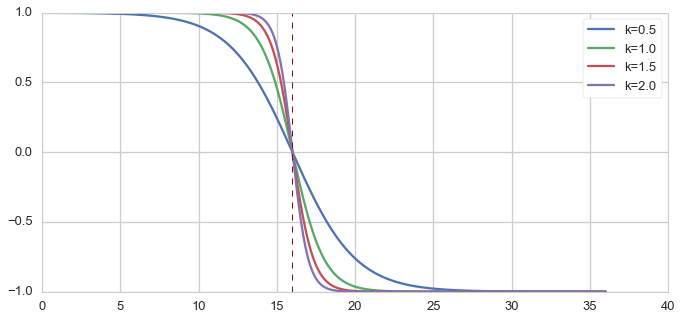

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

x0 = 16
x = np.linspace(0, 36, 1000)
plt.figure(figsize=(10, 5))
sns.set(style='whitegrid', context='talk')
sns.set_color_codes('dark')
for k in np.linspace(0.5, 2, 4):
    y = 2 / (1 + np.exp(k * (x - x0))) - 1
    plt.plot(x, y, label='k=%.1f' % k)
    
plt.plot([x0] * 20, np.linspace(-1, 1, 20), 'r--', lw=1.0)
plt.legend(frameon=True)
plt.show()

### Примеры планирования вывозных локомотивов

На плече Мариинск - Борзя работают вывозные локомотивы серии 2ЭС5К депо приписки Вихоревка. Эти локомотивы имеют номера от 80 до 87 включительно.

In [3]:
cols = ['loco', 'number', 'ser_name', 'depot_name', 'loc_name']
loco_info['ser_name'] = loco_info.series.map(loco_series.set_index('ser_id').ser_name)
loco_info.ser_name.fillna('-1', inplace=True)
loco_info['depot_name'] = loco_info.depot.map(st_names.name)
vyv = loco_info[(loco_info.ser_name.apply(lambda x: 'ЭС5К' in x)) & (loco_info.depot_name == 'ВИХОРЕВКА')
          & (loco_info.number >= 80) & (loco_info.number < 88)].sort_values(['depot_name', 'number'])
#nice_print(vyv, cols=cols, num=True)
vyv[cols]

,loco,number,ser_name,depot_name,loc_name
1261,200200031392,80,2ЭС5К,ВИХОРЕВКА,ТАЛЬЦЫ
1677,200200100898,81,2ЭС5К,ВИХОРЕВКА,ЛЕНА-ВОСТОЧНАЯ
1532,200200090764,82,2ЭС5К,ВИХОРЕВКА,НИЖНЕУДИНСК
1135,200200080455,84,2ЭС5К,ВИХОРЕВКА,ИРКУТСК-СОРТИРОВОЧНЫЙ
1729,200200058242,85,2ЭС5К,ВИХОРЕВКА,ИРКУТСК-СОРТИРОВОЧНЫЙ
1291,200200058339,86,2ЭС5К,ВИХОРЕВКА,ТАЙШЕТ


In [4]:
cols = ['loco', 'number', 'ser_name', 'regions', 'st_from_name', 'st_to_name', 'time_start', 'time_end', 'train']
loco_plan['ser_name'] = loco_plan.series.map(loco_series.set_index('ser_id').ser_name)
loco_plan['depot_name'] = loco_plan.depot.map(st_names.name)
a = loco_plan[loco_plan.loco.isin(vyv.loco)][cols]
start_st = a.drop_duplicates(subset=['loco', 'train'])
end_st = a.drop_duplicates(subset=['loco', 'train'], keep='last')
trips = start_st[['loco', 'regions', 'train', 'number', 'ser_name', 'st_from_name', 'time_start']].set_index(['loco', 'train'])\
    .join(end_st[['loco', 'train', 'st_to_name', 'time_end']].set_index(['loco', 'train']))\
    .reset_index()[cols].sort_values('number')
    
trips['tt'] = np.round(((trips.time_end - trips.time_start) / 3600), 2)
trips

,loco,number,ser_name,regions,st_from_name,st_to_name,time_start,time_end,train,tt
0,200200031392,80,2ЭС5К,['2002119299'],ТАЛЬЦЫ,УЛАН-УДЭ,1469590260,1469591411,88880005954781,0.32
1,200200031392,80,2ЭС5К,['2002119299'],УЛАН-УДЭ,ИРКУТСК-СОРТИРОВОЧНЫЙ,1469608800,1469641380,999912398012001,9.05
2,200200031392,80,2ЭС5К,['2002119299'],ИРКУТСК-СОРТИРОВОЧНЫЙ,УЛАН-УДЭ,1469649600,1469680820,9999060812000,8.67
3,200200031392,80,2ЭС5К,['2002119299'],УЛАН-УДЭ,УЛАН-УДЭ,1469682206,1469693006,-1,3.00
4,200200031392,80,2ЭС5К,['2002119299'],УЛАН-УДЭ,ИРКУТСК-СОРТИРОВОЧНЫЙ,1469693400,1469722441,88880020664247,8.07
5,200200031392,80,2ЭС5К,['2002119299'],ИРКУТСК-СОРТИРОВОЧНЫЙ,КАРЫМСКАЯ,1469725861,1469807739,9999051512006,22.74
6,200200058339,86,2ЭС5К,"['2002119299', '2002119301']",ТАЙШЕТ,ИЛАНСКАЯ,1469552280,1469561280,88880001234791,2.50
7,200200058339,86,2ЭС5К,"['2002119299', '2002119301']",ИЛАНСКАЯ,ИЛАНСКАЯ,1469561280,1469572080,-1,3.00
8,200200058339,86,2ЭС5К,"['2002119299', '2002119301']",ИЛАНСКАЯ,КРАСНОЯРСК-ВОСТОЧНЫЙ,1469583600,1469600139,88880004714471,4.59


<a id='pr_save'></a>

[В начало](#Содержание)
## Сохранение времени явки бригады при перепланировании

Для бригад, которые были запланированы на предыдущем запуске, будет передаваться ранее запланированное время явки $t_{prev}$. Если бригада была запланирована на явку ранее в достаточно близком горизонте от времени запуска планировщика, то ей нельзя сильно менять время явки, поскольку она, скорее всего, уже находится в пути из дома в депо, и мы не можем просто так заставить ее сидеть в ожидании поезда еще несколько часов или же заставлять отправляться раньше уже запланированного времени.

Предложения по доработке такие:

1. Назовем "пред-бригадой" бригаду, для которой передано $t_{prev}$.
2. Если для пред-бригады передано исходное состояние $state \neq 3$, то планировать ее по обычному алгоритму (т.к. она уже вышла на работу, для нее уже есть фактическая явка).
3. Если для пред-бригады передано исходное состояние $state = 3$, то устанавливать для нее $state = 2$ с временем явки = $t_{prev}$.
4. Для бригад со $state = 2$ ввести дополнительное слагаемое в функции полезности, которое бы сильно штрафовало за подвязку с локомотивам с поздним временем отправления (если бригада будет ждать локомотив) и сильно бы повышало полезность за подвязку к уже готовым к отправлению локомотивам. В этом случае бригада со $state = 2$ будет скорее подвязываться под готовые локомотивы и не будет сильно задерживаться на станции.
5. Предлагается в качестве этого слагаемого брать значение $$u(t) = \frac{2}{1 + \exp{k(t-t_0-\Delta)}} - 1$$
6. Параметры этой функции: 
  1. $t_0$ - время явки бригады (из сообщения factTeamReady или $t_{prev}$ из сообщения о пред-бригаде)
  2. $\Delta$ - допустимое отклонение от времени явки бригады. Оно зависит от "горизонта явки бригады":
    1. Если $t_0$ лежит на горизонте 3 часов от начала планирования, то $\Delta = 0.25$;
    2. Если $t_0$ лежит на горизонте 6 часов от начала планирования, то $\Delta = 0.5$;
    3. Если $t_0$ лежит на горизонте 12 часов от начала планирования, то $\Delta = 1.0$;    
  2. $k \approx \frac{10}{\Delta}$
  
7. TODO: Додумать такой момент: явку не двигать, но время отправления поезда сдвигать можно. Узнать у технологов, на сколько время отправления может быть позже времени явки.

k_opt = 30.4036, k_round = 20.00


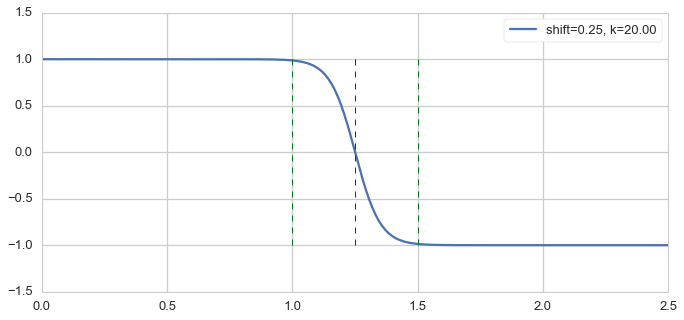

In [5]:
shift = 0.25
precision = 200
epsilon = 0.001
t_pres = 1
k_opt = np.log(2 / epsilon) / shift
k_round = 5 / shift
print('k_opt = %.4f, k_round = %.2f' % (k_opt, k_round))

x = np.linspace(-0, 2.5, precision)
y = 2/(1 + np.exp(k_round * ((x - t_pres) - shift))) - 1
yc = np.linspace(-1, 1, precision)
yc1 = [1.0] * precision
plt.figure(figsize=(10, 5))
sns.set(style='whitegrid', context='talk')
sns.set_color_codes('dark')
plt.plot(x, y, label='shift=%.2f, k=%.2f' % (shift, k_round))
plt.plot([t_pres + shift] * precision, yc, 'r--', lw=1.0)
plt.plot([t_pres] * precision, yc, 'g--', lw=1.0)
plt.plot([t_pres + 2 * shift] * precision, yc, 'g--', lw=1.0)
#plt.plot(x, [1.0] * precision, 'g--', lw=1.0)
axes = plt.gca()
axes.set_ylim([-1.5, 1.5])
plt.legend(frameon=True)
plt.show()

<a id='res'></a>

[В начало](#Содержание)
## Планирование пересылок резервом

Есть случаи очень дальней пересылки локомотивов резервом. Такая пересылка нерациональна: за те много часов, которые локомотив едет, может случиться что угодно - и локомотив уже окажется ненужным. Поэтому предлагается ограничить "окно" пересылки локомотивов резервом: искать локомотивы только на станциях, до которых ехать сравнительно недолго. В качестве такого окна предлагается взять 15 часов, затем корректировать при необходимости.

### Составляем таблицу с поездками локомотивов резервом

In [8]:
cols = ['loco', 'number', 'ser_name', 'st_from_name', 'st_to_name', 'time_start', 'time_end', 'train', 'n_state']
loco_plan['n_state'] = loco_plan.state.shift(-1)
loco_plan['loco_end'] = loco_plan.loco != loco_plan.loco.shift(-1)
loco_plan.loc[loco_plan.loco_end == True, 'n_state'] = -1
loco_plan_res = loco_plan[loco_plan.state == 0]
start_st = loco_plan_res.drop_duplicates(subset=['loco', 'train'])
end_st = loco_plan_res.drop_duplicates(subset=['loco', 'train'], keep='last')
trips = start_st[['loco', 'regions', 'train', 'number', 'ser_name', 'st_from_name', 'time_start']].set_index(['loco', 'train'])\
    .join(end_st[['loco', 'train', 'st_to_name', 'time_end', 'n_state']].set_index(['loco', 'train']))\
    .reset_index()[cols].sort_values('number')
    
trips['tt'] = np.round(((trips.time_end - trips.time_start) / 3600), 2)

# Загрузка "чистых" времен хода (не запланированных, без учета стоянок на смену бригад)
# Отсечка при планировании будет производиться именно по ним
default_tt = pd.read_csv(FOLDER + '/mandatory/travel_times_all_pairs.csv', sep=';')
def_tt = default_tt.set_index(['st_from_name', 'st_to_name']).to_dict()['tt']
trips['def_tt'] = trips.apply(lambda row: np.round(def_tt[(row.st_from_name, row.st_to_name)] / 3600, 2), axis=1)

cols = ['loco', 'number', 'ser_name', 'st_from_name', 'st_to_name', 'train', 'def_tt', 'tt']
nice_print(trips.sort_values('def_tt', ascending=False).head(), cols=cols)

         loco  number ser_name st_from_name             st_to_name           train  def_tt     tt
 200200048679     101    2ЭС5К        КИТОЙ            СМОЛЯНИНОВО  88880014924884   69.02  99.81
 200205819226     176    2ЭС5К    УССУРИЙСК  ИРКУТСК-СОРТИРОВОЧНЫЙ  88880018514785   65.61  76.50
 200200096178     351    3ЭС5К         БИРА  ИРКУТСК-СОРТИРОВОЧНЫЙ  88880015204855   57.81  60.33
 200200103339     165    3ЭС5К         БИРА                    КАЯ  88880015204837   57.68  60.52
 200200092530     167    2ЭС5К  ДУБИНИНСКИЙ                 ТАЛЬЦЫ  88880018134501   57.66  66.29


### Статистика по временам пересылок

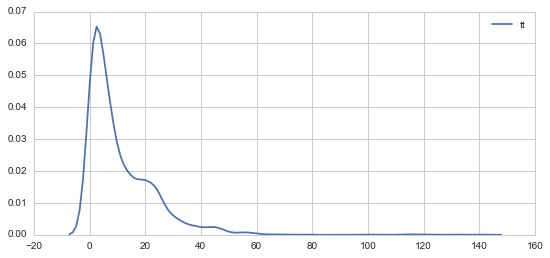

In [9]:
sns.set(style='whitegrid', context='notebook')
plt.figure(figsize=(8, 4))
sns.kdeplot(trips.tt)

### Поиск оптимальной границы

In [10]:
# От Войтенко: список примерных предельных маршрутов для локомотивов резервом

res_lims = [('НАХОДКА-ВОСТОЧНАЯ', 'ХАБАРОВСК II'), ('ХАБАРОВСК II', 'БЕЛОГОРСК II'),
('БЕЛОГОРСК II', 'СКОВОРОДИНО'), ('СКОВОРОДИНО', 'КАРЫМСКАЯ'), ('КАРЫМСКАЯ', 'УЛАН-УДЭ'), 
('УЛАН-УДЭ', 'ИРКУТСК-СОРТИРОВОЧНЫЙ'), ('ИРКУТСК-СОРТИРОВОЧНЫЙ', 'ТАЙШЕТ'), 
('ТАЙШЕТ', 'КРАСНОЯРСК-ВОСТОЧНЫЙ'), ('КРАСНОЯРСК-ВОСТОЧНЫЙ', 'МАРИИНСК')]

In [11]:
d = {}
for x in res_lims:
    d[x] = np.round(def_tt[x] / 3600, 2)    
lens = pd.DataFrame(d, index=np.arange(len(d.keys()))).transpose()[0]
print(lens.sort_values())

ТАЙШЕТ                 КРАСНОЯРСК-ВОСТОЧНЫЙ      6.93
КРАСНОЯРСК-ВОСТОЧНЫЙ   МАРИИНСК                  7.45
УЛАН-УДЭ               ИРКУТСК-СОРТИРОВОЧНЫЙ     7.83
БЕЛОГОРСК II           СКОВОРОДИНО              10.10
ИРКУТСК-СОРТИРОВОЧНЫЙ  ТАЙШЕТ                   11.46
ХАБАРОВСК II           БЕЛОГОРСК II             11.59
КАРЫМСКАЯ              УЛАН-УДЭ                 12.38
НАХОДКА-ВОСТОЧНАЯ      ХАБАРОВСК II             14.55
СКОВОРОДИНО            КАРЫМСКАЯ                19.55
Name: 0, dtype: float64


### Подсчет локомотивов, время пересылки резервом которых лежит за границей

In [35]:
lim_time = 15
print('Number of overtimed reserve trips: %d' % trips[trips.tt > lim_time].loco.count())
print('Rate of overtimed reserve trips: %.4f' % (trips[trips.tt > lim_time].loco.count() / trips.loco.count()))

Number of overtimed reserve trips: 595
Rate of overtimed reserve trips: 0.2756


### Выводы

1. В качестве верхней границы для времени пересылки локомотива резервом можно взять 15 часов. Из основных маршрутов локомотивов резервом такая отсечка сохранит все маршруты, кроме Сковородино - Карымская. Но по словам Войтенко, там возможна пересылка до Могочи. Впрочем, можно сделать исключение для локомотивов со станцией назначения Карымская в нечетном направлении - разрешить их пересылать при времени хода до 20 часов.
2. Всего в планах 20% от локомотивов, пересылающихся резервом, пересылаются на дальние расстояния (больше предельных 15 часов).
3. Пересылку на дальние расстояния резервом надо запретить и для пересылки на ТО. Впрочем, для любого положения локомотива наверняка найдется пункт ТО в радиусе этих 15 часов. Так что пока специальной проверки на это делать не надо. Имеющиеся случаи пересылки локомотивов на ТО с временем хода больше 15 часов - очень похожи на баги.

<a id='uth'></a>

[В начало](#Содержание)
## Планирование УТХ бригад

### Требования

УТХ планирует списочный состав бригад, которые выйдут на работу в депо в следующие сутки. Этот список был составлен по алгоритмам и данным, которые не используются в планировщике ОУЭР, поэтому эти бригады просто надо планировать раньше, чем другие бригады данного депо приписки.

### Входные данные

Для каждой бригады в планировщик ОУЭР передается три времени:
- время последней операции (oper_time);
- время последней явки в депо приписки (ready_time1);
- время последней явки в пункте оборота (ready_time2).

Также передается состояние бригады. Важным является состояние 3, оно соответствует тому, что бригада находится на домашнем отдыхе. Далее будем говорить **только про бригады в состоянии 3**.

Для УТХ-бригад в онтологию из УТХ передается планируемое время явки бригады. В планировщик ОУЭР оно передается как в атрибуте `ready_time1`, так и в атрибуте `oper_time`. Для не-УТХ-бригад в планировщик в атрибутах `oper_time` и `ready_time1` передается рассчитаное самое раннее допустимое время явки: это время ухода на отдых + 16 часов (для ухода на домашний отдых) или + 42 часа (для ухода на выходной день).

### Проблема

Может так получиться, что для не-УТХ-бригады рассчитанное время явки будет **меньше**, чем время явки какой-либо УТХ-бригады из данного депо. Такое может случиться, если не-УТХ-бригада ушла на отдых достаточно давно, но почему-то алгоритм УТХ не выбрал ее 
в списке бригад на следующие сутки (например, если всего было запрошено немного бригад или просто хватило более ранних бригад). В этом случае планировщик ОУЭР запланирует не-УТХ-бригаду раньше, чем какую-то УТХ-бригаду. А это неправильно.

Раньше (до 25.07.2016) такой проблемы не возникало (или она была не так заметна), поскольку сменно-суточное планирование ОУЭР запрашивало довольно много бригад. И в данном депо приписки просто не оставалось бригад, которые не попали в список бригад УТХ.

### Пути решения

В целом, не-УТХ-бригады надо каким-то образом задвигать на более позднее время. Например, можно в качестве планируемого времени явки не-УТХ-бригады брать не $t+16$ часов, а какое-то большее время, желательно за пределами текущих (следующих?) суток.

Предлагается вот какой вариант для определения времени явки для не-УТХ-бригады:

1. Берем самое позднее время явки среди всех УТХ-бригад данного депо приписки, которые были переданы в планировщик. Обозначим это время как $t_T$.
  1. Если в планировщик не было передано ни одной УТХ-бригады данного депо приписки, то для таких бригад ничего дополнительно не делаем, оставляем время явки неизменным.
2. Для каждой не-УТХ-бригады данного депо приписки считать разность $\Delta t = t_T - t_0$, где $t_0=\{t+16, t+42\}$ - планируемое (и передаваемое в планировщик) время явки этой бригады (увеличенное на 16 (42) часов время начала отдыха).
3. В качестве времени явки бригады брать значение $$t_N=t_T + 10 \cdot\exp{\left(-\frac{\Delta t}{20}\right)}$$
4. Таким образом мы гарантируем, что время явки не-УТХ-бригад будет больше времени явок всех УТХ-бригад. Если у не-УТХ-бригады время готовности достаточно раннее, то $t_T-t_0$ велико и новое время явки будет близко к $t_T$. Если у не-УТХ-бригады время готовности достаточно позднее (возможно, больше $t_T$), то новое время явки будет далеко в будущем от $t_T$. Значит, бригады, которые раньше готовы к отправлению, будут и планироваться раньше.
5. Коэффициенты в формуле (10 и 20 в примере выше) можно подобрать экспериментально. Графики распределения времен для коэффициентов 10 и 20 показаны ниже. Так, для этих значений мы получим, что для не-УТХ-бригады, у которой время явки на 12 часов меньше предельного $t_T$ (например, при явке последней УТХ-бригады в 17:00 и рассчитанной явке не-УТХ-бригады в 05:00) новое время явки не-УТХ-бригады будет $t_N \approx t_T + 5 = 22$.

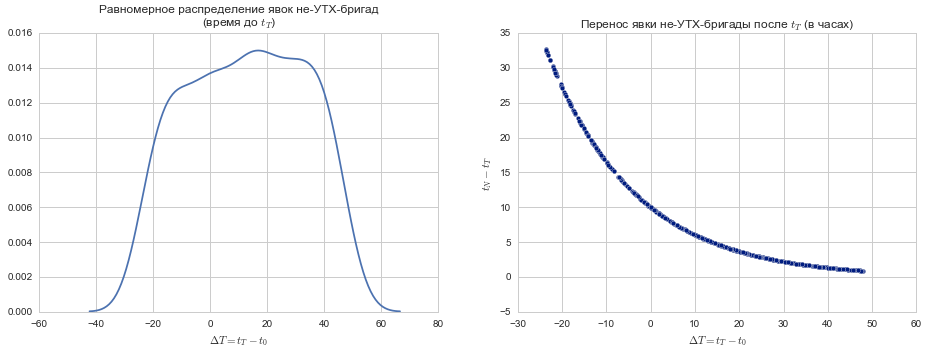

In [32]:
x = (np.random.randint(3 * 86400, size=500) / 3600) - 24
f = 10 * np.exp(-x/20)
plt.subplots(1, 2, figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.kdeplot(x)
plt.title('Равномерное распределение явок не-УТХ-бригад\n(время до $t_T$)')
plt.xlabel('$\Delta T = t_T - t_0$')
plt.subplot(1, 2, 2)
plt.title('Перенос явки не-УТХ-бригады после $t_T$ (в часах)')
plt.scatter(x, f)
plt.xlabel('$\Delta T = t_T - t_0$')
plt.ylabel('$t_N-t_T$')
plt.show()

Главный вопрос: где все эти операции производить - в онтологии при подготовке данных или в планировщике? Видимо, логичнее это делать в планировщике, поскольку эти расчеты уже не относятся напрямую к входным данным. Это скорее уже какое-то планирование, перенос каких-то бригад на более позднее время. 

Чтобы это реализовать в планировщике, к текущей реализации достаточно сделать такую доработку: для каждой бригады в сообщении `team_attributes` передавать атрибут `uth()`. Возможные значения признака: 0 - для не-УТХ-бригад, 1 - для УТХ-бригад. Получив этот признак для каждой бригады, планировщик сможет реализовать весь описанный выше алгоритм.

### FAQ

* **Что делать, если бригада была передана в планировщик ОУЭР как УТХ-бригада и была запланирована с каким-то временем явки, а на следующем запуске планировщика она уже передана как не-УТХ? Как в этом случае должен отработать алгоритм, который старается сохранить времена явок бригад между запусками?**

В принципе, таких случаев быть не должно. Если на одном запуске бригада является УТХ-бригадой, на втором нет, то значит, что между этими запусками планировщика ОУЭР был запуск планировщика УТХ. А значит, было и сменно-суточное планирование. После сменно-суточного планирования явки бригад не должны сохраняться.

Если все-таки такое случилось, то считаем, что УТХ-бригады более приоритетные, явки не-УТХ-бригад сдвигаем в будущее, даже если по ним были предыдущие явки.

* **Что делать на запуске планировщика в 16:30?**

На этом запуске мы должны допланировать старые УТХ-бригады (от предыдущих суток) на хвост 16:30 - 18:00, а затем запланировать новые. Значит, признак `uth` надо проставлять как для УТХ-бригад от прошлых суток, так и для свежих, которые были загружены перед запуском в 16:30.

* **А может УТХ-бригада от текущих суток успеть до запуска в 16:30 съездить на работу и уйти на домашний отдых?**

Может. Допустим, она отправлена из Иркутска в Зиму в 18:00. Время хода - около 5 часов. С учетом времени на приемку-сдачу можно сказать, что она уйдет на отдых в Зиму около 01:30. Ее минимальный отдых - около 4 часов, в 05:30 она выйдет на работу, может сразу принять локомотив и вернуться назад. Уход на домашний отдых может случиться примерно в 13:00. Это, конечно, достаточно экстремальный случай (должны сойтись звезды, что бригада была рано отправлена, отдыхала минимальное время и т.п.), но он возможен.

* **И что будет?**

Тогда будут проблемы. Потому что у этой бригады будет проставлен признак УТХ (от предыдущих суток). Время явки у нее будет либо полученное в предыдущих сутках от УТХ, либо время ухода на отдых + 16 часов (**уточнить у Варанкина**). В любом случае, она вполне сможет быть запланирована в следующих сутках, хотя в списке УТХ-бригад на следующие сутки ее, скорее всего, не будет.

Что делать с этим - пока непонятно. Наверное, в отсевах надо анализировать историю операций с бригадой: если бригада была в списке УТХ от текущих суток, ее нет в списке на следующие сутки и по ней были какие-то операции (кроме ухода на отдых) в текущие сутки, то передавать для нее признак `uth(0)`.

---
## Планы работ на ближайшее будущее

#### Задачи на Костю:

1. Фиксация времени явки от предыдущего расчета.
2. Сдвиг явки УТХ-бригад.
3. Пост-планирование (создание фейковых бригад для фейковых локомотивов).
4. Подвязывать поезда точно на нитки.
5. Возвратные скачки по времени. Достаточно много у локомотивов.
6. Бригады в state = 2:
  1. Неверно планируются (практически не подвязываются под поезда):
    1. Выявить случаи очень ранней явки, проверить по операциям, что случилось с бригадами.
    2. Написать постановку на учет (подвязывать их как можно скорее, явку не переносить).
  2. Создаются фейковые бригады только со state=2.
7. При расчете времени отдыха бригады не учитывается, что явка могла быть до начала планирования.
  1. Проверить. Возможно, уже исправлено.
8. Явка бригады создается до начала планирования.
9. Бесцельная пересадка бригады с поезда на поезд.
  1. Выявить (по возможности) все такие случаи. 
  
#### Задачи на Борю:

1. Фикс багов с ТО и ограничение времени на пересылку локомотивов резервом.
2. Пост-планирование и создание фейковых локомотивов.
3. 
